# Transformers, Self-Attention, BERT, GPT

In [11]:
#!pip install transformers torch datasets sentencepiece accelerate

In [12]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import (
    pipeline,
    AutoTokenizer,
    AutoModel,
    AutoModelForMaskedLM,
    AutoModelForSequenceClassification,
    AutoModelForCausalLM
)
import warnings
warnings.filterwarnings('ignore')

## Self-Attention: The Core Idea

### Multi-Head Attention (Why many heads?)

Visualize self-attention using PyTorch

In [13]:
import torch
import torch.nn.functional as F

# Dummy sequence of 5 tokens, embedding dim = 4
x = torch.randn(5, 4)

Wq = torch.randn(4, 4)
Wk = torch.randn(4, 4)
Wv = torch.randn(4, 4)

Q = x @ Wq
K = x @ Wk
V = x @ Wv

scores = (Q @ K.T) / (4 ** 0.5)   # scaled dot-product attention
attn = F.softmax(scores, dim=-1)

context_vector = attn @ V

attn, context_vector

(tensor([[5.9157e-02, 6.9360e-01, 3.1251e-02, 1.8877e-01, 2.7229e-02],
         [2.0782e-02, 2.1010e-06, 2.7867e-01, 6.0311e-05, 7.0048e-01],
         [3.2540e-02, 7.4757e-01, 5.1579e-03, 2.1335e-01, 1.3776e-03],
         [9.0617e-02, 2.1541e-03, 3.1924e-01, 7.8648e-03, 5.8013e-01],
         [1.1039e-01, 4.9476e-01, 2.2235e-02, 3.5776e-01, 1.4854e-02]]),
 tensor([[-0.9332, -0.8000,  1.8015, -2.4723],
         [ 0.9914,  0.6844,  0.5709, -0.4670],
         [-1.0799, -0.9395,  1.9359, -2.6627],
         [ 0.9283,  0.7255,  0.4426, -0.3466],
         [-0.7886, -0.6394,  1.5232, -2.1697]]))

### Transformer Architecture (Encoder/Decoder)

BERT Explained (Encoder Only)

In [14]:
from transformers import pipeline
bert = pipeline("fill-mask", model="bert-base-uncased")
bert("The capital of France is [MASK].")

Loading weights: 100%|██████████| 202/202 [00:00<00:00, 317.61it/s, Materializing param=cls.predictions.transform.dense.weight]                 
BertForMaskedLM LOAD REPORT from: bert-base-uncased
Key                         | Status     |  | 
----------------------------+------------+--+-
cls.seq_relationship.weight | UNEXPECTED |  | 
bert.pooler.dense.bias      | UNEXPECTED |  | 
bert.pooler.dense.weight    | UNEXPECTED |  | 
cls.seq_relationship.bias   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


[{'score': 0.4167889952659607,
  'token': 3000,
  'token_str': 'paris',
  'sequence': 'the capital of france is paris.'},
 {'score': 0.07141668349504471,
  'token': 22479,
  'token_str': 'lille',
  'sequence': 'the capital of france is lille.'},
 {'score': 0.0633925274014473,
  'token': 10241,
  'token_str': 'lyon',
  'sequence': 'the capital of france is lyon.'},
 {'score': 0.04444752633571625,
  'token': 16766,
  'token_str': 'marseille',
  'sequence': 'the capital of france is marseille.'},
 {'score': 0.030297257006168365,
  'token': 7562,
  'token_str': 'tours',
  'sequence': 'the capital of france is tours.'}]

### GPT Explained (Decoder Only)

In [15]:
from transformers import pipeline
gpt = pipeline("text-generation", model="gpt2")
gpt("Once upon a time in Bangalore,")[0]["generated_text"]

Loading weights: 100%|██████████| 148/148 [00:00<00:00, 447.13it/s, Materializing param=transformer.wte.weight]             
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


'Once upon a time in Bangalore, the residents of the town were all at a loss for what to do about it. In early August, the government was notified of a small earthquake in the town.\n\nIn the following days, residents in the city began to take action. The government had issued a warning to all residents and the city government had been sent to assess the situation. This was followed by a public meeting of the local residents at the city hall. The residents took to the streets and held demonstrations.\n\nOn August 14, local officials announced that they would be installing a tower in the village. It was called the "Japalahalli" (Japalahalli Tower).\n\nThe tower was built along the outskirts of the village. The people of Japalahalli were not pleased with the plan of the city government, so they began putting together a protest group that would be ready to take their place on the site.\n\nOn August 22, the city took over the government\'s work on the site. In the following week, the city 

#### BERT vs GPT (Simple Table)

#### Self-Attention is Parallel → Fast on GPUs

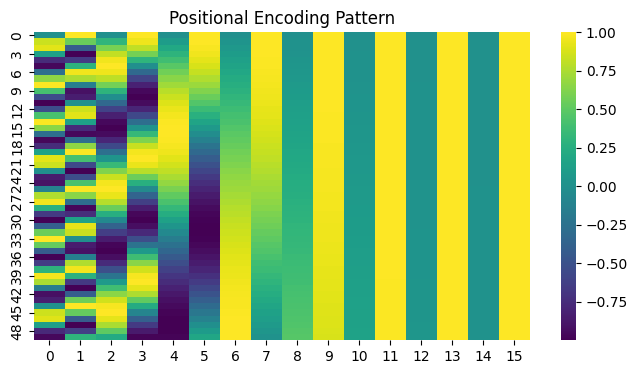

In [16]:
def positional_encoding(seq_len, d_model):
    PE = torch.zeros(seq_len, d_model)
    pos = torch.arange(0, seq_len).unsqueeze(1).float()  # shape [seq_len, 1]

    for i in range(0, d_model, 2):
        div_term = 10000 ** (i / d_model)
        PE[:, i] = torch.sin(pos.squeeze(1) / div_term)  # shape [seq_len]
        PE[:, i+1] = torch.cos(pos.squeeze(1) / div_term)
    return PE

PE = positional_encoding(50, 16)

plt.figure(figsize=(8,4))
sns.heatmap(PE.numpy(), cmap="viridis")
plt.title("Positional Encoding Pattern")
plt.show()

Full Transformer Block Diagram

Mini Transformer Attention Visualization (HF)

In [17]:
from transformers import AutoModel, AutoTokenizer
import torch

model = AutoModel.from_pretrained("bert-base-uncased", output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

inputs = tokenizer("Hello I am learning transformers!", return_tensors="pt")
outputs = model(**inputs)

attn = outputs.attentions  
len(attn), attn[0].shape   # (layers, batch, heads, tokens, tokens)

Loading weights: 100%|██████████| 199/199 [00:00<00:00, 458.53it/s, Materializing param=pooler.dense.weight]                               
BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


(12, torch.Size([1, 12, 8, 8]))

In [18]:
#!pip install tf-keras

In [19]:
from transformers import pipeline

fill = pipeline("fill-mask", model="bert-base-uncased")
fill("The capital of France is [MASK].")

Loading weights: 100%|██████████| 202/202 [00:00<00:00, 375.46it/s, Materializing param=cls.predictions.transform.dense.weight]                 
BertForMaskedLM LOAD REPORT from: bert-base-uncased
Key                         | Status     |  | 
----------------------------+------------+--+-
cls.seq_relationship.weight | UNEXPECTED |  | 
bert.pooler.dense.bias      | UNEXPECTED |  | 
bert.pooler.dense.weight    | UNEXPECTED |  | 
cls.seq_relationship.bias   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


[{'score': 0.4167889952659607,
  'token': 3000,
  'token_str': 'paris',
  'sequence': 'the capital of france is paris.'},
 {'score': 0.07141668349504471,
  'token': 22479,
  'token_str': 'lille',
  'sequence': 'the capital of france is lille.'},
 {'score': 0.0633925274014473,
  'token': 10241,
  'token_str': 'lyon',
  'sequence': 'the capital of france is lyon.'},
 {'score': 0.04444752633571625,
  'token': 16766,
  'token_str': 'marseille',
  'sequence': 'the capital of france is marseille.'},
 {'score': 0.030297257006168365,
  'token': 7562,
  'token_str': 'tours',
  'sequence': 'the capital of france is tours.'}]

In [20]:
clf = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

clf("what an good movie")

Loading weights: 100%|██████████| 104/104 [00:00<00:00, 347.83it/s, Materializing param=pre_classifier.weight]                                  


[{'label': 'POSITIVE', 'score': 0.999858021736145}]

BERT Sentence Embeddings (Used in RAG, LangChain)

In [21]:
tok = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")

text = "Transformers changed deep learning forever."
tokens = tok(text, return_tensors="pt")

with torch.no_grad():
    output = model(**tokens).last_hidden_state
    embedding = output.mean(dim=1)

embedding.shape

Loading weights: 100%|██████████| 199/199 [00:00<00:00, 433.54it/s, Materializing param=pooler.dense.weight]                               
BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


torch.Size([1, 768])

In [22]:
embedding

tensor([[ 4.8118e-01,  2.2254e-02,  2.3437e-01,  2.9283e-01,  1.5477e-01,
         -3.5160e-01,  3.6276e-01,  6.6813e-01,  2.6318e-01, -6.2313e-01,
          3.3251e-01, -1.2680e-01,  4.0204e-02,  4.2963e-01, -8.1284e-02,
          9.4661e-03, -9.2768e-03, -2.1423e-01,  1.2391e-01,  2.1578e-01,
         -5.5755e-02,  4.9718e-02, -1.1203e-02,  7.2107e-01,  2.4249e-01,
         -7.8887e-02, -1.3534e-01, -4.6789e-02, -2.8825e-01, -2.0091e-01,
         -4.5834e-02, -1.0742e-01, -1.5397e-02, -2.3608e-01, -2.8766e-01,
         -7.1730e-02, -1.3620e-01, -2.9062e-01, -2.6933e-01, -5.8896e-02,
         -5.6685e-01, -7.8516e-02,  6.8911e-02,  1.5713e-03, -1.7109e-01,
          3.9927e-04, -2.2543e-01, -8.7175e-02,  1.0485e-01, -1.0569e-01,
         -1.3154e-01, -4.8225e-02,  1.5725e-01,  1.5575e-01, -8.4317e-02,
          4.2958e-01,  1.1856e-01, -2.9336e-01, -1.3419e-01,  1.0632e-01,
          2.0947e-01,  4.6667e-01, -2.2501e-01, -1.9839e-01,  1.0379e-01,
          3.3701e-01, -4.6396e-01,  5.

BERT Attention Heatmap

Loading weights: 100%|██████████| 199/199 [00:00<00:00, 438.32it/s, Materializing param=pooler.dense.weight]                               
BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


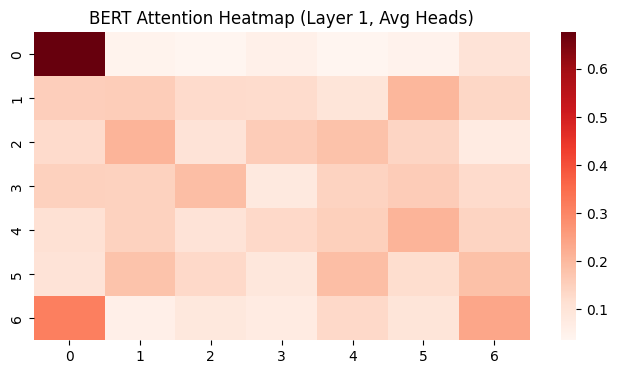

In [23]:
model = AutoModel.from_pretrained("bert-base-uncased", output_attentions=True)
tok = AutoTokenizer.from_pretrained("bert-base-uncased")

inputs = tok("Attention is all you need", return_tensors="pt")
outputs = model(**inputs)

attn = outputs.attentions[0][0]   # 1st layer, 1st batch = (heads, tokens, tokens)

plt.figure(figsize=(8,4))
sns.heatmap(attn.mean(0).detach().numpy(), cmap="Reds")
plt.title("BERT Attention Heatmap (Layer 1, Avg Heads)")
plt.show()

In [24]:
gen = pipeline("text-generation", model="gpt2", max_length=60)
gen("Once upon a time in Bangalore")[0]["generated_text"]

Loading weights: 100%|██████████| 148/148 [00:00<00:00, 358.36it/s, Materializing param=transformer.wte.weight]             
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'Once upon a time in Bangalore, I had a meeting with a few of our colleagues from the Bangalore University of Technology and I found out that the first one from the Bangalore University of Technology was a little bit of a bit of a jerk. He was'

In [25]:
print("\n--- BERT (Understanding) ---")
print(fill("The weather today is very [MASK]."))

print("\n--- GPT (Generation) ---")
print(gen("The weather today is very")[0]["generated_text"])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



--- BERT (Understanding) ---
[{'score': 0.22122995555400848, 'token': 4010, 'token_str': 'warm', 'sequence': 'the weather today is very warm.'}, {'score': 0.11510669440031052, 'token': 2204, 'token_str': 'good', 'sequence': 'the weather today is very good.'}, {'score': 0.09836212545633316, 'token': 2980, 'token_str': 'hot', 'sequence': 'the weather today is very hot.'}, {'score': 0.06650204211473465, 'token': 8242, 'token_str': 'pleasant', 'sequence': 'the weather today is very pleasant.'}, {'score': 0.066214919090271, 'token': 3147, 'token_str': 'cold', 'sequence': 'the weather today is very cold.'}]

--- GPT (Generation) ---
The weather today is very good and we're very happy to be able to bring you this update that will be working on Monday, August 21st, 2017.

Have fun and keep the updates coming!

"We will continue to update


How Transformers Power Agentic AI